# Data Analysis using XGBoost

In [1]:
%pylab inline
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from lib import XGBHelper as xgbh
import pandas as pd
from sklearn.metrics import roc_curve
from lib.logger import logger
xgb.__version__

def createDM(df):
    labels=df['label']
    features=df.drop('label',axis=1)
    return xgb.DMatrix(features, label=labels)

def split_data(df,frac=0.5):
    train = pd.DataFrame(df.sample(frac = 0.5))
    test = df.drop(train.index,axis=0)
    print(train.shape,test.shape,train.index.shape,df.shape)

    trainDM=createDM(train)
    testDM=createDM(test)
    AllDM=createDM(df)
    return trainDM,testDM,AllDM

# %load lib/Logger.py
import pandas as pd

class logger:
    """A helper class for defining a logger function and for parsing the
log, assuming it is created by XGBoost.
    Typical use:

    Logger=logger()
    logall=Logger.get_logger()

    bst = xgb.train(plst, dtrain, num_round, evallist, verbose_eval=False, callbacks=[logall])
    D=Logger.parse_log() #returns a dataframe with the logs.
    """
    def __init__(self):
        self.log=[]
         
    def get_logger(self):
        def logall(*argv,**argc):
            self.log.append(*argv)
        return logall

    def parse_log(self,ax=None):
        """ parse the log and generate plots"""
        D={'iter':[]}
        for _env in self.log:
            current_err={key:val for key,val in _env.evaluation_result_list}
            D['iter'].append(_env.iteration)
            for k in current_err.keys():
                if k in D:
                    D[k].append(current_err[k])
                else:
                    D[k]=[current_err[k]]
        for k in list(D.keys()):
            if len(D[k])==0:
                del D[k]

        df=pd.DataFrame(D)
        df=df.set_index('iter')
        test_col=[c for c in df.columns if 'eval' in c][0]
        print('test column=',test_col)
        _min=df[test_col].min()
        index_min=df[test_col].idxmin()
        title='min of %s=%f at %d'%(test_col,_min,index_min)
        if not ax is None:
            df.plot(grid=True,title=title,ax=ax)  
        return df

def test_xgboost(depth=1,num_round=100):
    param['max_depth']= depth   # depth of tree
    fig, axes = subplots(1,2,figsize=(12,5))
    i=0
    for _eval in ['error','logloss']:
        Logger=logger()
        logall=Logger.get_logger()  # Set logger to collect results
        param['eval_metric'] = _eval 
        bst = xgb.train(param, trainDM, num_round, evallist, verbose_eval=False, callbacks=[logall])
        df=Logger.parse_log(ax=axes[i])
        i+=1
    return bst,Logger
    
def gen_scale(n,reverse=False):
    s=np.arange(0,1,1/n)
    while s.shape[0] !=n:
        if s.shape[0]>n:
            s=s[:n]
        if s.shape[0]<n:
            s=np.arange(0,1,1/(n+0.1))
    if reverse:
        s=s[-1::-1]
    return s

def solve(x1,x2,y1,y2):
    b=(y1-y2)/(x1-x2)
    a=0.5*(y1+y2-b*(x1+x2))
    return a,b

def generate_samples(data, size=500, num_chunks=20):
    for i in range(200):
        if i == 0:
            min_cuv = np.zeros(num_chunks, dtype=float)
            max_cuv = np.zeros(num_chunks, dtype=float)
            min_ger = np.zeros(num_chunks, dtype=float)
            max_ger = np.zeros(num_chunks, dtype=float)
        
        #Sampling Random indices for selection
        samp_indices = np.random.randint(len(data), size=size)
        
        #Test data and labels
        X_samp = data[samp_indices, :-1]
        y_samp = np.array(data[samp_indices, -1], dtype=int)
        
        #Test predictions
        dsamp = xgb.DMatrix(X_samp, label=y_samp)    
        y_samp_pred = bst.predict(dsamp, iteration_range=[0,bst.best_ntree_limit], output_margin=True)

        thresholds_samp = sorted(np.unique(np.round(y_samp_pred, 2)))
        error_cuv_samp, error_ger_samp = xgbh.get_error_values(y_samp_pred, y_samp, thresholds_samp)
        
        min_cuv_samp, max_cuv_samp, min_ger_samp, max_ger_samp = get_error_ranges(error_cuv_samp, error_ger_samp, thresholds_samp)
        
        if i == 0:
            min_cuv = min_cuv_samp
            max_cuv = max_cuv_samp
            min_ger = min_ger_samp
            max_ger = max_ger_samp
        else:
            min_cuv[min_cuv > min_cuv_samp] = min_cuv_samp[min_cuv > min_cuv_samp]
            max_cuv[max_cuv < max_cuv_samp] = max_cuv_samp[max_cuv < max_cuv_samp]
            min_ger[min_ger > min_ger_samp] = min_ger_samp[min_ger > min_ger_samp]
            max_ger[max_ger < max_ger_samp] = max_ger_samp[max_ger < max_ger_samp]         
    
    for i in range(20):
        plt.plot([min_cuv[i], max_cuv[i]], [i/20.0, i/20.0], 'b')
        plt.plot([min_ger[i], max_ger[i]], [i/20.0, i/20.0], 'r')

def get_error_ranges(error_cuv_samp, error_ger_samp, thresholds_samp, num_chunks=20):
    error_cuv_bin = np.array(np.array(error_cuv_samp) * num_chunks, dtype=int)
    error_cuv_bin[error_cuv_bin == num_chunks] = num_chunks - 1
    error_ger_bin = np.array(np.array(error_ger_samp) * num_chunks, dtype=int)
    error_ger_bin[error_ger_bin == num_chunks] = num_chunks - 1
    
    min_cuv = np.zeros(num_chunks, dtype=float)
    max_cuv = np.zeros(num_chunks, dtype=float)
    min_ger = np.zeros(num_chunks, dtype=float)
    max_ger = np.zeros(num_chunks, dtype=float)
    
    normalizing_factor = (max(thresholds_samp) - min(thresholds_samp))
    
    for i in range(num_chunks):
        min_cuv[i] = thresholds_samp[np.min(np.where(error_cuv_bin == i))]/normalizing_factor
        max_cuv[i] = thresholds_samp[np.max(np.where(error_cuv_bin == i))]/normalizing_factor
        min_ger[i] = thresholds_samp[np.min(np.where(error_ger_bin == i))]/normalizing_factor
        max_ger[i] = thresholds_samp[np.max(np.where(error_ger_bin == i))]/normalizing_factor
            
    return min_cuv, max_cuv, min_ger, max_ger


Populating the interactive namespace from numpy and matplotlib


In [2]:
dir = '/net/birdstore/Active_Atlas_Data/cell_segmentation/DK55/all_features_modified.csv'
df = pd.read_csv(dir)
drops = ['animal', 'section', 'index', 'row', 'col'] 
df=df.drop(drops,axis=1)
df = df.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)

## Setting Parameters for XG Boost
* Maximum Depth of the Tree = 3 _(maximum depth of each decision trees)_
* Step size shrinkage used in update to prevents overfitting = 0.3 _(how to weigh trees in subsequent iterations)_
* Maximum Number of Iterations = 1000 _(total number trees for boosting)_
* Early Stop if score on Validation does not improve for 5 iterations

[Full description of options](https://xgboost.readthedocs.io/en/latest//parameter.html)

In [7]:
param={'max_depth': 3,
 'eta': 0.3,
 'objective': 'binary:logistic',
 'nthread': 50,
 'eval_metric': 'logloss'}
 
trainDM,testDM,allDM=split_data(df)
evallist = [(trainDM, 'train'), (testDM, 'eval')]
num_round=500

(400612, 41) (400612, 41) (400612,) (801224, 41)


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-error


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-logloss


(<xgboost.core.Booster at 0x7f2cd9a10970>, <__main__.logger at 0x7f2cd026c400>)

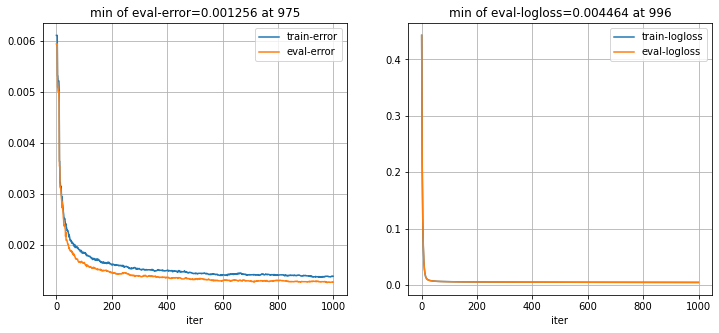

In [10]:
test_xgboost(depth=1,num_round=1000)

/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-error


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-logloss


(<xgboost.core.Booster at 0x7f2b45ccd220>, <__main__.logger at 0x7f2b45cc4b50>)

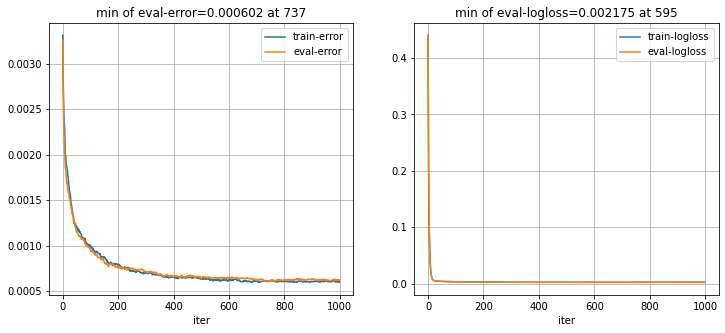

In [13]:
test_xgboost(depth=3,num_round=1000)

/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-error


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-logloss


(<xgboost.core.Booster at 0x7f15a8618d30>, <__main__.logger at 0x7f1414eaa760>)

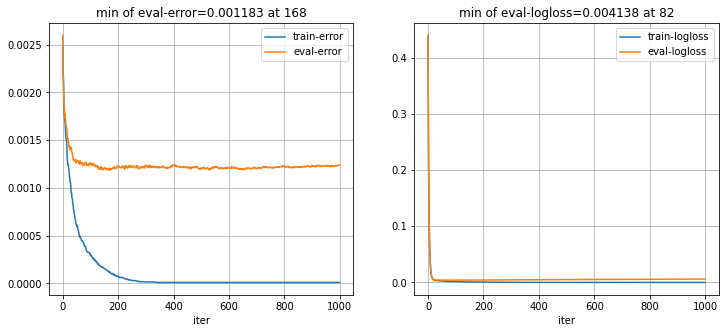

In [6]:
test_xgboost(depth=4,num_round=1000)

/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-error


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-logloss


(<xgboost.core.Booster at 0x7f2cdd4ca4f0>, <__main__.logger at 0x7f2cbcd10340>)

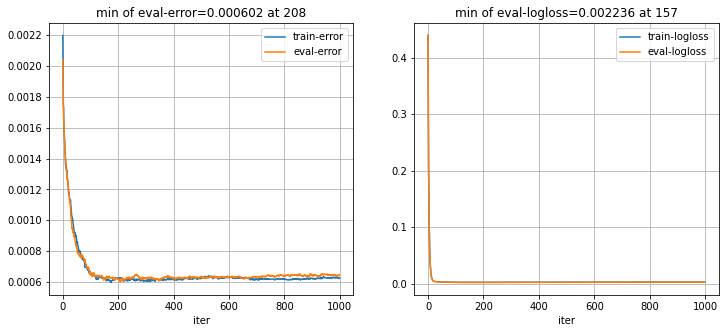

In [11]:
test_xgboost(depth=5,num_round=1000)

/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-error


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-logloss


(<xgboost.core.Booster at 0x7f2cbcb5f790>, <__main__.logger at 0x7f2cbd96b2e0>)

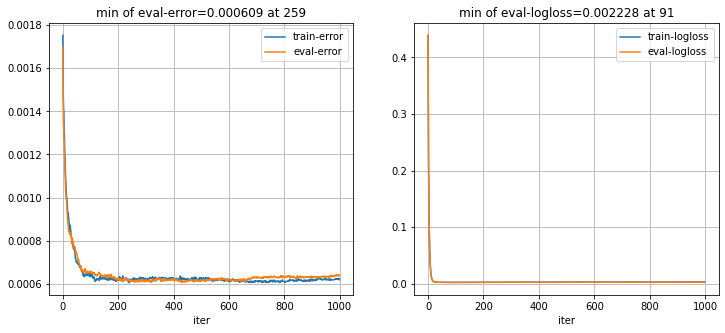

In [14]:
test_xgboost(depth=7,num_round=1000)

/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-error


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


test column= eval-logloss


(<xgboost.core.Booster at 0x7f2cd023d1f0>, <__main__.logger at 0x7f2cd024b0d0>)

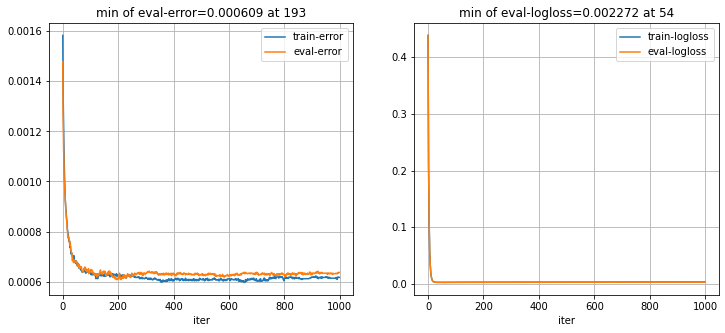

In [12]:
test_xgboost(depth=10,num_round=1000)

## ROC graph
* Often false positive and false negatives have different cost.
* Different tradeoffs between false positives and false negatives can be gotten using different thresholds.
* The [ROC Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) is a good way to visualize the tradeoffs. 

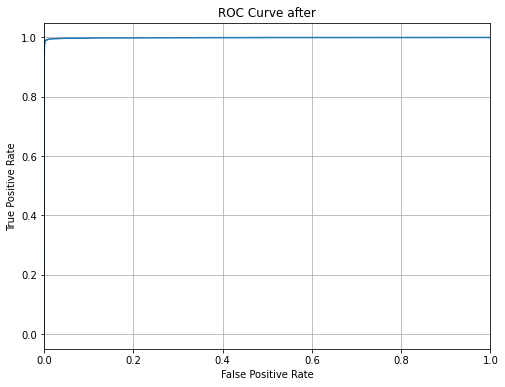

In [8]:
bst = xgb.train(param, trainDM, num_round, evallist, verbose_eval=False)
y_pred = bst.predict(testDM, iteration_range=[1,bst.best_ntree_limit], output_margin=True)
y_test=testDM.get_label()

plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve after")
plt.grid()
plt.show()

## Stability of the Margins.
Margins on the training set are predictive of margins of the test set, which is why margins are a better measure of performance than the training error.

(6271,) (394341,)


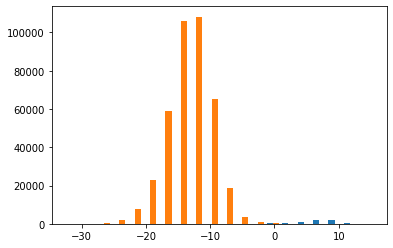

In [9]:
y_test=testDM.get_label()
pos_preds=y_pred[y_test==1]
neg_preds=y_pred[y_test==0]
print(pos_preds.shape,neg_preds.shape)
plt.hist([pos_preds,neg_preds],bins=20);

## Training the detector

(400612, 41) (400612, 41) (400612,) (801224, 41)
(400612, 41) (400612, 41) (400612,) (801224, 41)
(400612, 41) (400612, 41) (400612,) (801224, 41)
(400612, 41) (400612, 41) (400612,) (801224, 41)
(400612, 41) (400612, 41) (400612,) (801224, 41)
(400612, 41) (400612, 41) (400612,) (801224, 41)
(400612, 41) (400612, 41) (400612,) (801224, 41)
(400612, 41) (400612, 41) (400612,) (801224, 41)
(400612, 41) (400612, 41) (400612,) (801224, 41)
(400612, 41) (400612, 41) (400612,) (801224, 41)
(400612, 41) (400612, 41) (400612,) (801224, 41)
(400612, 41) (400612, 41) (400612,) (801224, 41)
(400612, 41) (400612, 41) (400612,) (801224, 41)
(400612, 41) (400612, 41) (400612,) (801224, 41)
(400612, 41) (400612, 41) (400612,) (801224, 41)
(400612, 41) (400612, 41) (400612,) (801224, 41)
(400612, 41) (400612, 41) (400612,) (801224, 41)
(400612, 41) (400612, 41) (400612,) (801224, 41)
(400612, 41) (400612, 41) (400612,) (801224, 41)
(400612, 41) (400612, 41) (400612,) (801224, 41)
(400612, 41) (400612

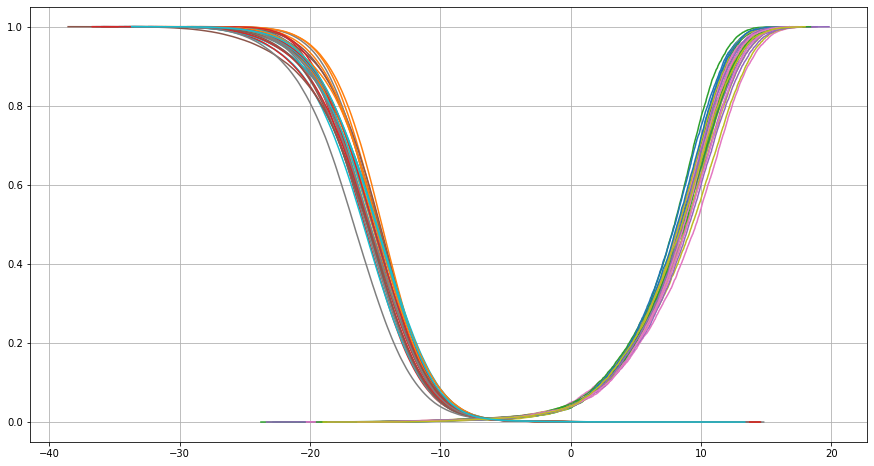

In [10]:
plt.figure(figsize=[15,8])
num_round=737
bst_list=[]
for i in range(30):
    trainDM,testDM,allDM=split_data(df)
    bst = xgb.train(param, trainDM, num_round, evallist, verbose_eval=False)
    bst_list.append(bst)
    y_pred = bst.predict(testDM, iteration_range=[1,bst.best_ntree_limit], output_margin=True)
    y_test=testDM.get_label()
    pos_preds=y_pred[y_test==1]
    neg_preds=y_pred[y_test==0]
    pos_preds=np.sort(pos_preds)
    neg_preds=np.sort(neg_preds)
    plt.plot(pos_preds,gen_scale(pos_preds.shape[0]));
    plt.plot(neg_preds,gen_scale(neg_preds.shape[0],reverse=True))
grid();

In [11]:
DATA_DIR='/data/cell_segmentation/'
import pickle as pk
with open(DATA_DIR+'BoostedTrees_r2.pkl','bw') as pkl_file:
    pk.dump(bst_list,pkl_file)
!ls -lh $DATA_DIR/*.pkl

-rw-rw-r-- 1 zhw272 dklab  51K Jan 11 10:48 /data/cell_segmentation//average_cell_image.pkl
-rw-r--r-- 1 zhw272 dklab 7.0M Jan 11 10:41 /data/cell_segmentation//BoostedTrees.pkl
-rw-r--r-- 1 zhw272 dklab  27M Jan 26 15:00 /data/cell_segmentation//BoostedTrees_r2.pkl


### Skip to here for testing without training

In [3]:
import pickle as pk
DATA_DIR='/data/cell_segmentation/'
with open(DATA_DIR+'BoostedTrees_r2.pkl','br') as pkl_file:
    bst_list=pk.load(pkl_file)

In [12]:
df.head()

,label,area,height,width,corr_CH1,energy_CH1,corr_CH3,energy_CH3,m00CH_3,m10CH_3,...,nu03CH_3,h0_CH_3,h1_CH_3,h2_CH_3,h3_CH_3,h4_CH_3,h5_CH_3,h6_CH_3,contrast1,contrast3
0,0.0,12.0,4.0,6.0,0.417143,0.520628,0.696434,0.785642,12.0,488.0,...,0.005262,0.200810,0.008207,0.000984,0.000141,4.279279e-08,0.000013,3.000172e-08,1.035443,0.885097
1,0.0,68.0,10.0,10.0,0.490175,0.592464,0.832646,0.859799,68.0,2757.0,...,0.002573,0.175259,0.002115,0.000936,0.000033,3.601095e-09,0.000001,4.431751e-09,0.965334,0.889440
2,0.0,157.0,11.0,22.0,0.678732,0.396908,1.099261,0.753719,157.0,6380.0,...,-0.000583,0.250962,0.035942,0.000007,0.000008,2.240240e-11,0.000001,-5.556936e-11,0.978335,0.777349
3,0.0,9.0,5.0,4.0,0.414359,0.243328,0.946792,0.640843,9.0,364.0,...,0.000000,0.249657,0.002785,0.016068,0.001225,5.406360e-06,0.000032,5.349767e-07,1.058626,0.763469
4,0.0,2.0,2.0,1.0,0.261996,0.166857,0.752815,0.551227,2.0,80.0,...,0.000000,0.125000,0.015625,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,1.062515,0.767290


## Scoring segments

In [13]:
print('loading data')
dir = '/net/birdstore/Active_Atlas_Data/cell_segmentation/DK55/all_features_modified.csv'
df = pd.read_csv(dir)
df = df.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)
drops = ['animal', 'section', 'index', 'row', 'col'] 
df=df.drop(drops,axis=1)
print('score and predict')
trainDM,testDM,AllDM=split_data(df)
labels=AllDM.get_label()
scores=np.zeros([df.shape[0],len(bst_list)])
for i in range(len(bst_list)):
    bst=bst_list[i]
    scores[:,i] = bst.predict(AllDM, iteration_range=[1,bst.best_ntree_limit], output_margin=True) 

_max=np.max(scores,axis=1)
_min=np.min(scores,axis=1)
_mean=np.mean(scores,axis=1)
_std=np.std(scores,axis=1)




loading data
score and predict
(400612, 41) (400612, 41) (400612,) (801224, 41)


## Predict if segment is cell

In [21]:
from numpy import *
from pylab import plot
def points2line(p1,p2,i):
    x1,y1=p1
    x2,y2=p2
    a=(y1-y2)/(x1-x2)
    b=y1-a*x1
    #plotline(a,b,i)
    return a,b

p=[[0,1],[2.5,3.5],[1,4.3],[-2.5,2.5],[-10,6],[10,6]]
def plotline(a,b,i):
    X=arange(-5,5,0.01)
    Y=a*X+b
    plot(X,Y,label=str(i))
    
def aboveline(p,l):
    return l[0]*p[0]+l[1] < p[1]

L=[]
L.append(points2line(p[0],p[1],0))
L.append(points2line(p[1],p[2],1))
L.append(points2line(p[2],p[3],2))
L.append(points2line(p[3],p[0],3))
L.append(points2line(p[1],p[5],4))
L.append(points2line(p[3],p[4],5))

def decision(x,y):
    p=[x,y]
    if aboveline(p,L[0]) and not aboveline(p,L[1])\
    and not aboveline(p,L[2]) and aboveline(p,L[3]):
        return 0
    if (x<0 and not aboveline(p,L[5])) or (x>0 and aboveline(p,L[4])):
        return -2
    if (x>0 and not aboveline(p,L[4])) or (x<0 and aboveline(p,L[5])):
        return 2

# from DefinePredictor import *
df['mean_score']=_mean
df['std_score']=_std
predictions=[]
for i,row in df.iterrows():
    p=decision(float(row['mean_score']),float(row['std_score']))
    predictions.append(p)

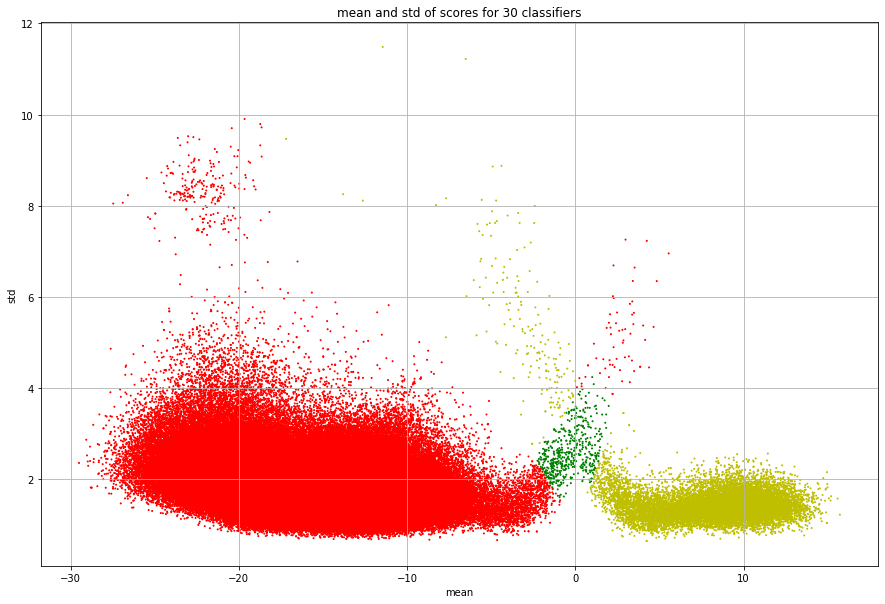

In [22]:
from collections import Counter
Counter(predictions)
figure(figsize=[15,10])
cmap={-2:'r',
      -1:'b',
      0:'g',
      1:'m',
      2:'y',
      3:'c'}
_colors=[cmap[int(i)] for i in list(predictions)]
scatter(_mean,_std,c=_colors,s=1)

title('mean and std of scores for 30 classifiers')
xlabel('mean')
ylabel('std')
grid()

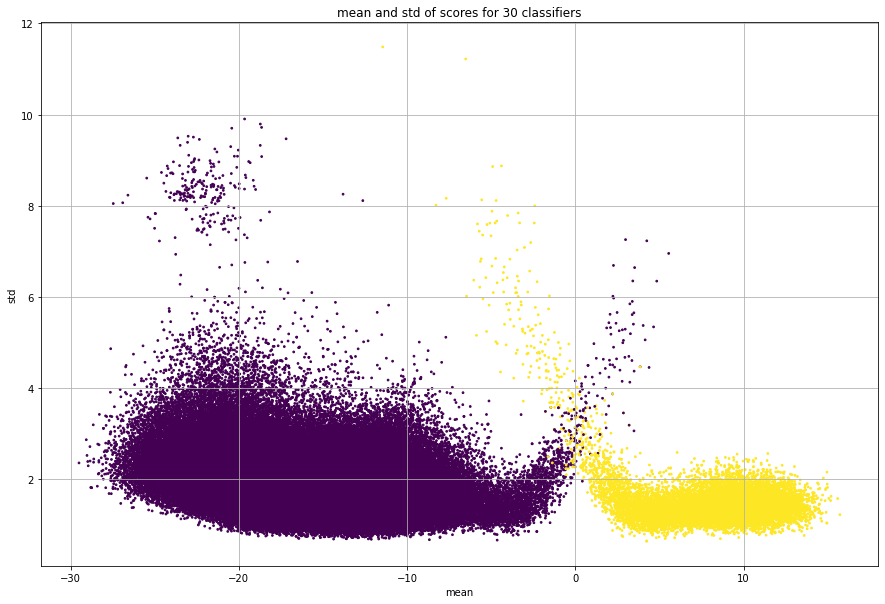

In [23]:

figure(figsize=[15,10])
plt.scatter(_mean,_std,c=labels,s=3)

plt.title('mean and std of scores for 30 classifiers')
plt.xlabel('mean')
plt.ylabel('std')
plt.grid()



In [24]:
print('loading data')
dir = '/net/birdstore/Active_Atlas_Data/cell_segmentation/DK55/all_features_modified.csv'
df = pd.read_csv(dir)
df = df.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)
df['predictions']=predictions
df['mean_score']=_mean
df['std_score']=_std
detection_df=df[df['predictions']!=-2]
detection_df = detection_df[['animal', 'section', 'row', 'col','label', 'mean_score',
       'std_score', 'predictions']]
detection_df.head()

loading data


,animal,section,row,col,label,mean_score,std_score,predictions
28,DK55,132.0,18851.0,37633.0,1.0,1.921801,1.732860,2
74,DK55,145.0,17423.0,38133.0,1.0,9.701313,1.197953,2
98,DK55,145.0,17638.0,37839.0,1.0,5.571584,1.603937,2
111,DK55,145.0,17708.0,37724.0,1.0,12.840085,1.894537,2
127,DK55,145.0,17794.0,37634.0,1.0,8.711579,1.587325,2


In [25]:
df.to_csv(DATA_DIR+'demo_scores.csv')
detection_df.to_csv(DATA_DIR+'detections_DK55_round2.csv',index=False)

In [26]:
!head $DATA_DIR/detections_DK55_round2.csv

animal,section,row,col,label,mean_score,std_score,predictions
DK55,132.0,18851.0,37633.0,1.0,1.9218014284968377,1.732859664320483,2
DK55,145.0,17423.0,38133.0,1.0,9.701313225428263,1.19795301384983,2
DK55,145.0,17638.0,37839.0,1.0,5.5715843446552755,1.6039370425994368,2
DK55,145.0,17708.0,37724.0,1.0,12.840084552764893,1.8945366225453666,2
DK55,145.0,17794.0,37634.0,1.0,8.711579163869223,1.5873253886441676,2
DK55,145.0,18024.0,37820.0,1.0,5.42039494117101,1.3416692512594255,2
DK55,145.0,18184.0,37758.0,1.0,10.174085474014282,1.3400361546142527,2
DK55,145.0,18284.0,37824.0,1.0,10.772542794545492,1.3889220820660768,2
DK55,145.0,19410.0,37405.0,1.0,3.1920666893323264,1.3016009941260434,2


In [42]:
from collections import Counter
Counter(predictions)

Counter({-2: 788730, 2: 10703, 0: 1791})

In [49]:
np.unique(labels)

array([0., 1.], dtype=float32)

In [47]:
np.unique(predictions)

array([-2,  0,  2])

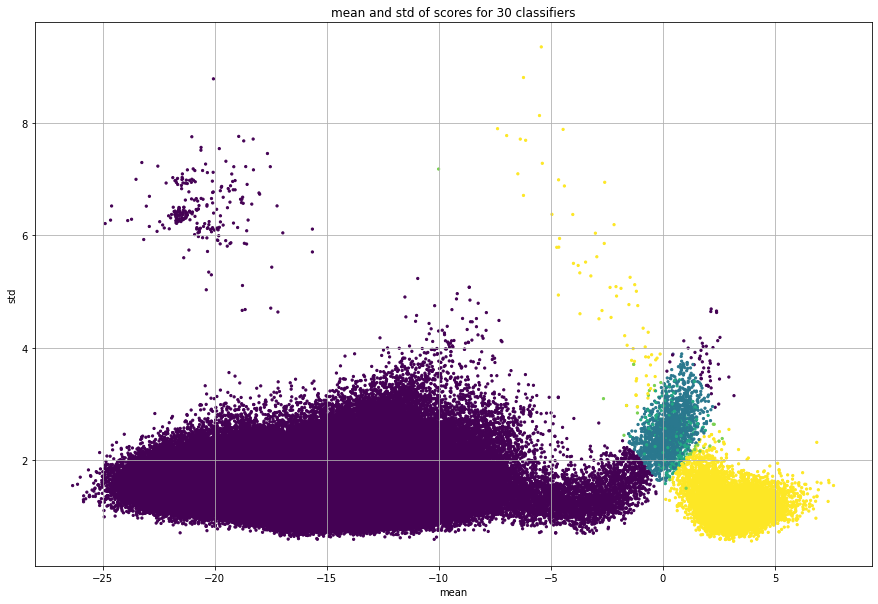

In [43]:
figure(figsize=[15,10])
scatter(_mean,_std,c=predictions+labels,s=5)
title('mean and std of scores for 30 classifiers')
xlabel('mean')
ylabel('std')
grid()

In [ ]:
def plot_margins(_train_size):
    plt.figure(figsize=(8, 6))
    for i in range(10):
        trainDM,testDM=split_data(df)
        legends=[]
        # Use early_stopping_rounds=5 to enable early stopping
        for num_round in [100]:
            bst = xgb.train(param, trainDM, num_round, evallist, verbose_eval=False)
            y_pred = bst.predict(testDM, iteration_range=[0,bst.best_ntree_limit], output_margin=True)
            thresholds = sorted(np.unique(np.round(y_pred, 2)))
            error_cuv, error_ger = xgbh.get_error_values(y_pred, y_test, thresholds)
            legends += ['Cuviers %d'%num_round, 'Gervais %d'%num_round]
            _style=['y','g'] if num_round==100 else ['b', 'r']
            xgbh.get_margin_plot(error_cuv, error_ger, thresholds, legends = legends, style=_style)
        
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
        thr = thresholds/(np.max(thresholds) - np.min(thresholds))
    plt.title('data_size=%4.3f'%(X_train.shape[0]))
    plt.show()

In [ ]:
plot_margins(0.03)

In [ ]:
plot_margins(0.1)

In [ ]:
plot_margins(0.8)

## Per example variation analysis
The CDFs provide information on the variation of the aggregate. If we want to estimate of the confidence on a single examples we need to compute the variance **per example**

In [ ]:
data  = np.load("Data/processed_data_15mb.np")
data.shape

* Each line segment represents the average man and std of a set of examples, stratified by thei score.

In [ ]:
plt.figure(figsize=(8, 6))
#legends = ['Cuviers', 'Gervais']

#Best thresholds from the ROC Analysis
thr_lower_index = np.min(np.where((tpr > 0.95)))
thr_upper_index = np.max(np.where((tpr  < 0.6)))
thr_lower, thr_upper = thresholds[thr_lower_index], thresholds[thr_upper_index]
thr_lower_norm = thr_lower/(np.max(thresholds) - np.min(thresholds))
thr_upper_norm = thr_upper/(np.max(thresholds) - np.min(thresholds))
print("Thresholds (lower, upper):", thr_lower_norm, thr_upper_norm)


generate_samples(data, num_chunks=20)

#xgbh.get_margin_plot(error_cuv_100, error_ger_100, thresholds_100, legends = legends, style=['y', 'g'])
plt.plot([thr_lower_norm, thr_lower_norm], [0, 1], 'm:')
plt.plot([thr_upper_norm, thr_upper_norm], [0, 1], 'm:')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.xlabel('Score')
plt.ylabel('CDF')
legends = ['Cuviers_100', 'Gervais_100']
plt.legend(legends)
plt.show()

# Summary
* We saw how PCA+Boosting are used to solve a real-world problem.

* We saw several ways to quantify and understand the behaviour of boosted trees.
   * Train and test error
   * Train and test loss
   * ROC curves
   * Stability of scores

* Next Time: **Neural Networks**